# Prepare Dissociated AnnData object

## Load environment

In [5]:
import numpy as np
import pandas as pd

import scanpy as sc

In [6]:
import mofax as mofa
import muon as mu
import decoupler as dc

In [7]:
import liana as li
import plotnine as p9

In [8]:
li.__version__

'0.1.8'

### Load Data

In [9]:
adata = sc.read_h5ad("/home/dbdimitrov/Repos/liana2_manuscript/data/kidney_injury/GSE139107_MouseIRI.h5ad")
adata

AnnData object with n_obs × n_vars = 126578 × 27133
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Group', 'Replicates', 'celltype', 'ident'
    uns: 'X_name'

In [10]:
adata.obs['ident'].cat.categories

Index(['IRI12h1b1', 'IRI12h1b2', 'IRI12h2', 'IRI12h3', 'IRI14d1b1',
       'IRI14d1b2', 'IRI14d2', 'IRI14d3', 'IRI2d1b1', 'IRI2d1b2', 'IRI2d2b1',
       'IRI2d2b2', 'IRI2d3', 'IRI4h1', 'IRI4h2', 'IRI4h3', 'IRI6w1b1',
       'IRI6w1b2', 'IRI6w2', 'IRI6w3', 'IRIsham1b1', 'IRIsham1b2', 'IRIsham2',
       'IRIsham3'],
      dtype='object')

In [11]:
list(adata.obs['celltype'].unique()) 
# should aggregate those into cell types (get rid off cell states)

['CTAL2',
 'NewPT1',
 'EC1',
 'DCT',
 'MTAL',
 'ICA',
 'Fib',
 'PTS3',
 'PTS2',
 'PTS1',
 'DCT-CNT',
 'Mø',
 'PC2',
 'ICB',
 'PC1',
 'CTAL1',
 'DTL-ATL',
 'Per',
 'PEC',
 'CNT',
 'NewPT2',
 'Pod',
 'Tcell',
 'EC2',
 'MD',
 'Uro']

In [20]:
adata.obs.rename(columns={'celltype': 'cell_state'}, inplace=True)

In [21]:
ct_dict = {
    # PT
    "NewPT1":"PT",
    "NewPT2":"PT",
    "PTS1":"PT", # Segment 1
    "PTS2":"PT", # Segment 2
    "PTS3":"PT", # Segment 3
    # CTAL
    "CTAL1":"CTAL",
    "CTAL2":"CTAL",
    # EC
    "EC1":"EC",
    "EC2":"EC",
    "PC1": "PC",
    "PC2": "PC",
    
    # Rename Macrophages
    "Mø": "MO",
    }
abbr_dict = {
    "ATL": "Ascending tubule of loop of Henle",
    "Bil": "Bilateral",
    "CNT": "Connecting tubule",
    "CPC": "Collecting duct principal cell (in cortex)",
    "CTAL": "Thick ascending limb of loop of Henle",
    "DCT": "Distal convoluted tubule",
    "DTL": "Descending tubule of loop of Henle",
    "EC": "Epithelial cell",
    "Fib": "Fibroblast",
    "ICA": "Intercalated cell of collecting duct",
    "ICB": "Type B intercalated cell",
    "MD": "Mucula densa",
    "MO": "Macrophages",
    "Pod": "Podocyte",
    "Uro": "Urothelium",
    "PT":"Proximal tubule",
}

adata.obs['cell_type'] = adata.obs['cell_state'].replace(ct_dict)
adata.obs['ct_full'] = adata.obs['cell_type'].replace(abbr_dict)

In [22]:
list(adata.obs['cell_type'].unique())

['CTAL',
 'PT',
 'EC',
 'DCT',
 'MTAL',
 'ICA',
 'Fib',
 'DCT-CNT',
 'MO',
 'PC',
 'ICB',
 'DTL-ATL',
 'Per',
 'PEC',
 'CNT',
 'Pod',
 'Tcell',
 'MD',
 'Uro']

In [23]:
# columns of interest
sample_key = "ident"
groupby = "cell_type"
condition_key = "Group"

## QC

In [24]:
# set filtering parameters
min_cells = 15 # min number of cells per cell type
min_samples = 10 # min number of samples that pass the threshold per cell type

# get cell num per sample per cluster
celltype_qc = adata.obs.groupby([sample_key, groupby]).size().reset_index(name='counts')
# check which rows (sample-cell type combo) pass threshold
celltype_qc['keep_min'] = celltype_qc['counts'] >= min_cells
# how many samples passed the threshold
celltype_qc['keep_sum'] = celltype_qc.groupby(groupby)['keep_min'].transform('sum')
# identify which cell types don't pass sample threshold
celltype_qc['keep_celltype'] = celltype_qc['keep_sum'] >= min_samples
celltype_qc = celltype_qc[[sample_key, groupby, "keep_sum", 'keep_min', 'keep_celltype']]
# drop duplicates
celltype_qc = celltype_qc.drop_duplicates()

In [25]:
celltype_qc.drop_duplicates([groupby, "keep_celltype"])

,ident,cell_type,keep_sum,keep_min,keep_celltype
0,IRI12h1b1,CNT,24,True,True
1,IRI12h1b1,CTAL,24,True,True
2,IRI12h1b1,DCT,24,True,True
3,IRI12h1b1,DCT-CNT,22,True,True
4,IRI12h1b1,DTL-ATL,24,True,True
5,IRI12h1b1,EC,24,True,True
6,IRI12h1b1,Fib,24,True,True
7,IRI12h1b1,ICA,24,True,True
8,IRI12h1b1,ICB,24,True,True
9,IRI12h1b1,MD,2,False,False


In [26]:
adata.obs = adata.obs.reset_index().merge(celltype_qc, how='left').set_index('index')
adata.obs.index.name = None

In [27]:
adata = adata[(adata.obs['keep_min']) & (adata.obs['keep_celltype']), :]

In [28]:
adata.obs[groupby]

IRI4h1_AAACCTGAGATCTGCT      CTAL
IRI4h1_AAACCTGAGATTACCC        PT
IRI4h1_AAACCTGAGTGTTAGA        EC
IRI4h1_AAACCTGCACCAACCG       DCT
IRI4h1_AAACCTGCAGCCTGTG      MTAL
                             ... 
IRIsham3_TTTGTCATCAGGTTCA      EC
IRIsham3_TTTGTCATCATAACCG      PC
IRIsham3_TTTGTCATCCGTCATC      PT
IRIsham3_TTTGTCATCCTTCAAT      PT
IRIsham3_TTTGTCATCGTCCGTT      PT
Name: cell_type, Length: 126158, dtype: category
Categories (18, object): ['CNT', 'CTAL', 'DCT', 'DCT-CNT', ..., 'Per', 'Pod', 'Tcell', 'Uro']

### Normalize

In [29]:
adata.layers['counts'] = adata.X.copy()

/tmp/ipykernel_15205/1155977868.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [30]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## MOFAcell

In [31]:
mdata = li.multi.adata_to_views(adata,
                                groupby=groupby,
                                sample_key=sample_key,
                                obs_keys=[condition_key],
                                min_prop=0.05, # min cell prop nnz values (filter features)
                                min_smpls=3, # min samples per view (filter features)
                                min_cells=25, # min cells per view (filter samples)
                                min_counts=100, # min counts per view (filter samples)
                                mode='sum', # mode of aggregation
                                verbose=True,
                                layer='counts'
                                )


100%|██████████| 18/18 [00:35<00:00,  1.97s/it]


In [32]:
mdata

MuData object with n_obs × n_vars = 24 × 101633
  obs:	'Group'
  18 modalities
    CTAL:	24 x 5511
      layers:	'psbulk_props'
    PT:	24 x 6201
      layers:	'psbulk_props'
    EC:	24 x 4482
      layers:	'psbulk_props'
    DCT:	24 x 5727
      layers:	'psbulk_props'
    MTAL:	24 x 5487
      layers:	'psbulk_props'
    ICA:	24 x 6554
      layers:	'psbulk_props'
    Fib:	24 x 5962
      layers:	'psbulk_props'
    DCT-CNT:	18 x 6337
      layers:	'psbulk_props'
    MO:	23 x 5330
      layers:	'psbulk_props'
    PC:	24 x 5794
      layers:	'psbulk_props'
    ICB:	22 x 6999
      layers:	'psbulk_props'
    DTL-ATL:	23 x 6074
      layers:	'psbulk_props'
    Per:	5 x 2282
      layers:	'psbulk_props'
    PEC:	8 x 5638
      layers:	'psbulk_props'
    CNT:	24 x 6026
      layers:	'psbulk_props'
    Pod:	15 x 6098
      layers:	'psbulk_props'
    Tcell:	9 x 3118
      layers:	'psbulk_props'
    Uro:	20 x 8013
      layers:	'psbulk_props'

In [33]:
views = dict()
for view in mdata.mod.keys():
    # dc.plot_filter_by_expr(mdata.mod[view], min_count=10, min_total_count=200)
    keep_genes = dc.filter_by_expr(mdata.mod[view], group=None, min_count=5, min_total_count=20, min_prop=0.1, large_n=0)
    mdata.mod[view] = mdata.mod[view][:, keep_genes].copy()
    
    sc.pp.normalize_total(mdata.mod[view], target_sum=1e4)
    sc.pp.log1p(mdata.mod[view])
    sc.pp.highly_variable_genes(mdata.mod[view])
    
    views[view] = mdata.mod[view]

In [34]:
import mudata

In [35]:
obs = mdata.obs
# rebuild with re-filtered features
mdata = mudata.MuData(views)
mdata.obs = obs

In [36]:
mdata

MuData object with n_obs × n_vars = 24 × 91009
  obs:	'Group'
  var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
  18 modalities
    CTAL:	24 x 5511
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
      layers:	'psbulk_props'
    PT:	24 x 6201
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
      layers:	'psbulk_props'
    EC:	24 x 4482
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
      layers:	'psbulk_props'
    DCT:	24 x 5727
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
      layers:	'psbulk_props'
    MTAL:	24 x 5487
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
      layers:	'psbulk_props'
    ICA:	24 x 6331
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
      layers:	'psbulk_props'
    Fib:	24 x 5962
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
      layers:	'psbulk_props'
    DCT-CNT:	18 x 5964
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
      layers:	'psbulk_props'
    MO:	23 x 5157
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
      layers:	'psbulk_props'
    PC:	24 x 5794
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
      layers:	'psbulk_props'
    ICB:	22 x 6651
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
      layers:	'psbulk_props'
    DTL-ATL:	23 x 6074
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
      layers:	'psbulk_props'
    Per:	5 x 993
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
      layers:	'psbulk_props'
    PEC:	8 x 3326
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
      layers:	'psbulk_props'
    CNT:	24 x 6026
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
      layers:	'psbulk_props'
    Pod:	15 x 3337
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
      layers:	'psbulk_props'
    Tcell:	9 x 1761
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
      layers:	'psbulk_props'
    Uro:	20 x 6225
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
      layers:	'psbulk_props'

In [37]:
mu.tl.mofa(mdata,
           use_obs='union',
           convergence_mode='medium',
           n_factors=5,
           outfile='models/mofacell.h5ad',
           use_var='highly_variable'
           )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='CTAL' group='group1' with N=24 samples and D=1386 features...
Loaded view='PT' group='group1' with N=24 samples and D=1537 features...
Loaded view='EC' group='group1' with N=24 samples and D=1149 features...
Loaded view='DCT' group='group1' with N=24 samples and D=1431 features...
Loaded view='MTAL' group='group1' with N=24 samples and D=1400 features...
Loaded view

In [38]:
# obtain factor scores
factor_scores = li.multi.get_factor_scores(mdata, obsm_key='X_mofa')
factor_scores.head()

,ident,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Group
0,IRI12h1b1,0.821762,-0.093489,-0.150936,0.037851,-0.016032,12hours
1,IRI12h1b2,0.811791,-0.035442,-0.140246,0.058600,-0.015732,12hours
2,IRI12h2,0.786622,-0.076981,-0.147285,0.029764,-0.014254,12hours
3,IRI12h3,0.798339,-0.058759,-0.143811,0.049447,-0.013502,12hours
4,IRI14d1b1,-0.369209,-0.120413,0.009520,-0.001651,0.072180,14days


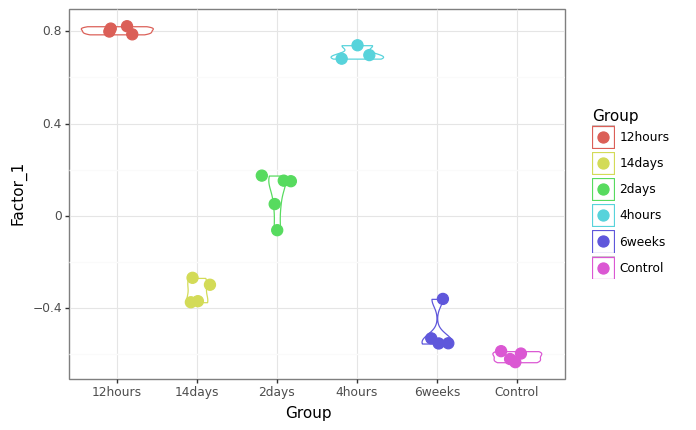

<ggplot: (8735743367090)>

In [39]:
(p9.ggplot(factor_scores) +
 p9.aes(x=condition_key, colour=condition_key, y='Factor_1') +
 p9.geom_violin() +
 p9.geom_jitter(size=4, width=0.2) +
 p9.theme_bw()
 )

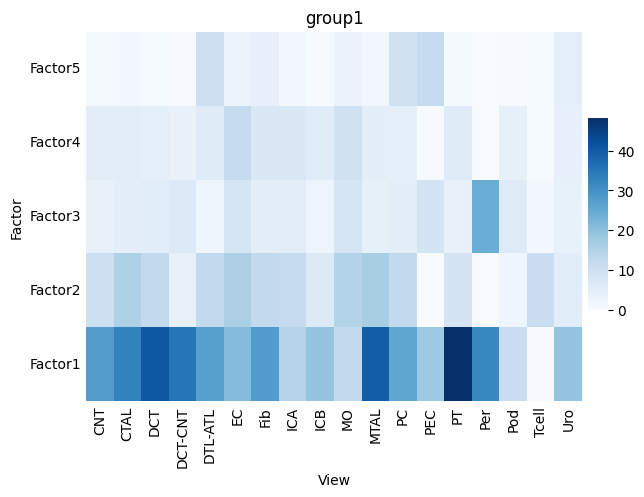

In [44]:
model = mofa.mofa_model("models/mofacell.h5ad")
model
mofa.plot_r2(model, x='View')

In [41]:
factor1_loadings =  li.multi.get_variable_loadings(mdata, 0, view_separator=':') # get loadings for factor 1
factor1_loadings.head()

,loadings,view,variable
10457,-2.147949,PT,Slc7a13
17634,-2.094414,DCT,Egf
18815,-2.007379,DCT,Klhl3
10356,-1.879177,PT,Slc22a30
17131,1.854527,DCT,Chd9


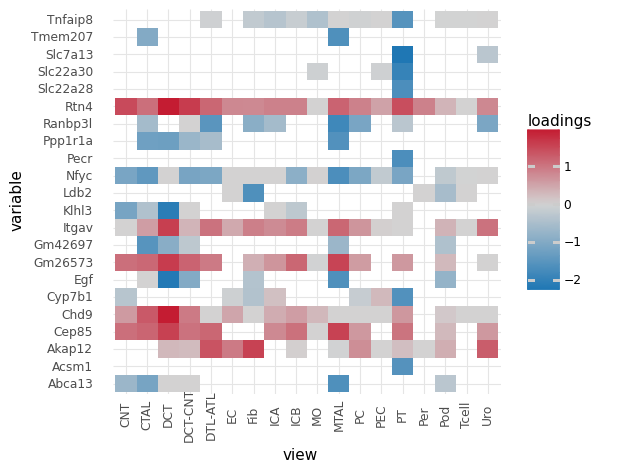

<ggplot: (8735838093081)>

In [42]:
# get 25 genes with highest loadings across all views
top_genes = factor1_loadings['variable'].head(25)
top_loadings = factor1_loadings[factor1_loadings['variable'].isin(top_genes)]
# ^ Note that the genes with the lowest loadings are equally interesting

# plot them
# dotplot of variable, view, loadings
(p9.ggplot(top_loadings) +
 p9.aes(x='view', y='variable', fill='loadings') +
 p9.geom_tile() +
 p9.scale_fill_gradient2(low='#1f77b4', mid='lightgray', high='#c20019') +
 p9.theme_minimal() +
 p9.theme(axis_text_x=p9.element_text(angle=90, hjust=0.5, vjust=0.5), figure_size=(5, 5))
 )

## MOFAtalk

## Run LIANA

In [43]:
score_key = 'lrscore'

In [ ]:
li.method.singlecellsignalr.by_sample(adata,
                                      groupby=groupby,
                                      sample_key=sample_key,
                                      resource_name='mouseconsensus',
                                      use_raw=False,
                                      verbose=True,
                                      n_perms=None,
                                      return_all_lrs=False
                                      )

In [ ]:
adata.uns['liana_full'] = adata.uns['liana_res'].copy()

In [ ]:
adata.uns['liana_res'] = adata.uns['liana_res'][adata.uns['liana_res']['lrs_to_keep']]

In [ ]:
mdata = li.multi.lrs_to_views(adata,
                              sample_key=sample_key,
                              score_key=score_key,
                              obs_keys=[condition_key], # add those to mdata.obs
                              lr_prop = 0.2, # minimum required proportion of samples to keep an LR
                              lrs_per_sample = 20, # minimum number of interactions to keep a sample in a specific view
                              lrs_per_view = 20, # minimum number of interactions to keep a view
                              samples_per_view = 5, # minimum number of samples to keep a view
                              min_variance = 0, # minimum variance to keep an interaction
                              lr_fill = 0.5, # fill missing LR values across samples with this
                              verbose=True
                              )

In [ ]:
mu.tl.mofa(mdata,
           use_obs='union',
           convergence_mode='medium',
           outfile='models/mofatalk.h5ad',
           n_factors=4,
           )

In [ ]:
# obtain factor scores
factor_scores = li.multi.get_factor_scores(mdata, obsm_key='X_mofa')
factor_scores.head()

In [ ]:
# scatterplot
(p9.ggplot(factor_scores) +
 p9.aes(x='Group', colour='Group', y='Factor_1') +
 p9.geom_violin() +
 p9.geom_jitter(size=4, width=0.2) +
 p9.theme_bw()
 )

In [ ]:
model = mofa.mofa_model("models/mofatalk.h5ad")
model

In [ ]:
# get variance explained by view and factor
rsq = model.get_r2()
factor1_rsq = rsq[rsq['Factor']=='Factor1']
# separate view column
factor1_rsq[['source', 'target']] = factor1_rsq['View'].str.split('&', 1, expand=True)

(p9.ggplot(factor1_rsq.reset_index()) +
 p9.aes(x='target', y='source') +
 p9.geom_tile(p9.aes(fill='R2')) +
 p9.scale_fill_gradient2(low='white', high='#c20019') +
 p9.theme_bw()
 )

In [ ]:
# load PROGENy pathways
net = dc.get_progeny(organism='Mus musculus', top=5000)
# load full list of ligand-receptor pairs
lr_pairs = li.resource.select_resource('mouseconsensus')

# generate ligand-receptor geneset
lr_progeny = li.fun.generate_lr_geneset(lr_pairs, net, lr_separator="^")
lr_progeny.head()

In [ ]:
lr_loadings =  li.multi.get_variable_loadings(mdata,
                                              0, # get loadings for factor 1
                                              view_separator=':',
                                              )
lr_loadings.set_index('variable', inplace=True)

In [ ]:
lr_loadings[lr_loadings['view'].str.contains('PT')].sort_values('loadings', ascending=False).tail()

In [ ]:
# pivot views to wide
lr_loadings = lr_loadings.pivot(columns='view', values='loadings')
# replace NaN with 0
lr_loadings.replace(np.nan, 0, inplace=True)
lr_loadings.head()

In [ ]:
# run pathway enrichment analysis
estimate, pvals =  dc.run_mlm(lr_loadings.transpose(), lr_progeny,
                              source="source", target="interaction",
                              use_raw=False, min_n=5)
# pivot columns to long
estimate = (estimate.
            melt(ignore_index=False, value_name='estimate', var_name='pathway').
            reset_index().
            rename(columns={'index':'view'})
            )

## p9 tile plot
(p9.ggplot(estimate) +
 p9.aes(x='pathway', y='view') +
 p9.geom_tile(p9.aes(fill='estimate')) +
 p9.scale_fill_gradient2(low='#1f77b4', high='#c20019') +
 p9.theme_bw(base_size=14) +
 p9.theme(figure_size=(10, 20))
)


In [ ]:
import cell2cell as c2c
from collections import defaultdict

In [ ]:
tensor = li.multi.to_tensor_c2c(adata,
                                uns_key='liana_full',
                                sample_key=sample_key,
                                score_key=score_key, # can be any score from liana
                                how='outer_cells' # how to join the samples
                                )

In [ ]:
c2c.io.export_variable_with_pickle(tensor, "tensor_aki.pkl")

In [ ]:
tensor.shape

In [ ]:
context_dict = adata.obs[[sample_key, condition_key]].drop_duplicates()
context_dict = dict(zip(context_dict[sample_key], context_dict[condition_key]))
context_dict = defaultdict(lambda: 'Unknown', context_dict)

tensor_meta = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                  metadata_dicts=[context_dict, None, None, None],
                                                  fill_with_order_elements=True
                                                  )

In [ ]:
import gc
gc.collect()

In [ ]:
tensor = c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                                    tensor_meta,
                                                    copy_tensor=True, # Whether to output a new tensor or modifying the original
                                                    rank=10, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis. Here, it was precomuputed.
                                                    tf_optimization='regular', # To define how robust we want the analysis to be.
                                                    random_state=0, # Random seed for reproducibility
                                                    device='cpu', # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                                    elbow_metric='error', # Metric to use in the elbow analysis.
                                                    smooth_elbow=False, # Whether smoothing the metric of the elbow analysis.
                                                    upper_rank=20, # Max number of factors to try in the elbow analysis
                                                    tf_init='random', # Initialization method of the tensor factorization
                                                    tf_svd='numpy_svd', # Type of SVD to use if the initialization is 'svd'
                                                    cmaps=None, # Color palettes to use in color each of the dimensions. Must be a list of palettes.
                                                    sample_col='Element', # Columns containing the elements in the tensor metadata
                                                    group_col='Category', # Columns containing the major groups in the tensor metadata
                                                    output_fig=False, # Whether to output the figures. If False, figures won't be saved a files if a folder was passed in output_folder.
                                                    )



In [ ]:
factors, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensor,
                                                 metadata = tensor_meta, # This is the metadata for each dimension
                                                 sample_col='Element',
                                                 group_col='Category',
                                                 meta_cmaps = ['Dark2_r', None, 'tab20', 'tab20'],
                                                 fontsize=10, # Font size of the figures generated
                                                 )